In [15]:
import pandas as pd
import os
from ortools.linear_solver import pywraplp
import numpy as np

In [2]:
result_dir = '../results/FP_Truthful_Oracle_sigmoids_1run1pub'
files = os.listdir(result_dir)

In [3]:
conc_res = pd.concat(
    [pd.read_csv(os.path.join(result_dir, file)) for file in files]
)

In [10]:
mean_res = conc_res.groupby('publisher').agg({
    'impressions': 'mean',
    'clicks': 'mean',
    'true_clicks': 'mean',
    'spent': 'mean',
}).reset_index()

In [30]:
# Salvataggio
mean_res.to_csv(f"{result_dir}/mean_results.csv", index=False)

## Esperimento

In [6]:
exp_dir = '../results/FP_blabla_mulruns_different/'
exp_files = [file for file in os.listdir(exp_dir) if file.endswith('.csv')]
exp_stats = pd.concat(
    [pd.read_csv(os.path.join(exp_dir, file)) for file in exp_files]
)

In [9]:
exp_pub_list = list(exp_stats[exp_stats['Iteration']==0]['publisher'].unique())

## Stats medie dei 300 publisher

In [12]:
mean_stats = mean_res[mean_res['publisher'].isin(exp_pub_list)]

## Applico Knapsack

In [ ]:
def get_data(
        df: pd.DataFrame,
):
    # Estraggo i dati dal dataframe
    n = df.shape[0]
    clicks = df['clicks'].values
    impressions = df['impressions'].values
    spent = df['spent'].values
    return n, clicks, impressions, spent

In [16]:
def solver(
        df: pd.DataFrame,
        n: int,
        clicks: np.ndarray = None,
        impressions: np.ndarray = None,
        spent: np.ndarray = None,
        cpc: np.ndarray = None,
        soglia_spent: float = None,
        soglia_clicks: float = None,
        soglia_cpc: float = None,
        soglia_ctr: float = None,
        soglia_num_publisher: int = None,
):
    # Inizializzo il solver
    solver = pywraplp.Solver.CreateSolver('SCIP')
    # Definisco le variabili
    x = [solver.BoolVar(f'x{i}') for i in range(n)]
    x_np = np.array(x)
    # Funzione obiettivo
    solver.Maximize(np.dot(clicks, x_np))
    if soglia_clicks is not None:
        # Vincolo Clicks
        solver.Add(np.dot(clicks, x_np) >= soglia_clicks)
    if soglia_spent is not None:
        # Vincolo Spesa
        solver.Add(np.dot(spent, x_np) <= soglia_spent)
    if soglia_cpc is not None:
        # Vincolo CPC
        solver.Add(np.dot(cpc, x_np) <= soglia_cpc)
    if soglia_ctr is not None:
        # Vincolo CTR
        solver.Add(np.dot(clicks, x_np) >= soglia_ctr * np.dot(impressions, x_np))
    if soglia_num_publisher is not None:
        # Vincolo Numero Publisher
        solver.Add(sum(x_np) <= soglia_num_publisher)
    # Risolvo il problema
    status = solver.Solve()
    results = pd.DataFrame(columns=df.columns)
    # Output dei risultati
    if status == pywraplp.Solver.OPTIMAL:
        for i in range(n):
            if x[i].solution_value() == 1:
                if results.empty:
                    results = df.iloc[[i]]
                else:
                    results = pd.concat([results, df.iloc[[i]]])
        print("Knapsack Solver: Soluzione ottimale trovata!")
        print(f"Valore obiettivo = {round(solver.Objective().Value(), 3)}")
        impressions_sum = results['impressions'].sum()
        if impressions_sum != 0:
            print(f"CTR = {round(results['clicks'].sum() / impressions_sum * 100, 3)}%")
        else:
            print(f"CTR = {0}%")
    else:
        print("Knapsack Solver: Non è stata trovata una soluzione ottimale.")
        # Return empty dataframe
        return pd.DataFrame()
    return results

In [17]:
n, clicks, impressions, spent = get_data(mean_stats)

In [18]:
soglia_ctr = 0.97
results = solver(
    mean_stats,
    n,
    clicks=clicks,
    impressions=impressions,
    soglia_ctr=soglia_ctr,
)

Knapsack Solver: Soluzione ottimale trovata!
Valore obiettivo = 4312.86
CTR = 97.001%


In [21]:
opt_ctr = results['clicks'].sum() / results['impressions'].sum()
opt_clicks = results['clicks'].sum()
print(f"CTR ottimale = {opt_ctr}")
print(f"Clicks ottimali = {opt_clicks}")

CTR ottimale = 0.970008164256749
Clicks ottimali = 4312.86


## Confronto con i risultati dell'esperimento

In [22]:
# Prima raggruppo per Run e Iteration per avere il dato aggregato per ogni iterazione
grouped_results_run_iter = exp_stats.groupby(['Run', 'Iteration']) \
    .agg({'clicks': 'sum', 'impressions': 'sum', 'true_clicks':'sum', 'exp_rew':'sum'}) \
    .reset_index()
grouped_results_iter = grouped_results_run_iter.groupby('Iteration').mean().reset_index()
grouped_results_iter['ctr'] = grouped_results_iter['clicks'] / grouped_results_iter['impressions']
grouped_results_iter['true_ctr'] = grouped_results_iter['true_clicks'] / grouped_results_iter['impressions']

### aggiungo errore tra clicks e optimal clicks

In [24]:
grouped_results_iter['error_clicks'] = np.abs(grouped_results_iter['clicks'] - opt_clicks)
grouped_results_iter['percentage_error_clicks'] = np.abs(grouped_results_iter['clicks'] - opt_clicks) / opt_clicks * 100

<AxesSubplot:xlabel='Iteration'>

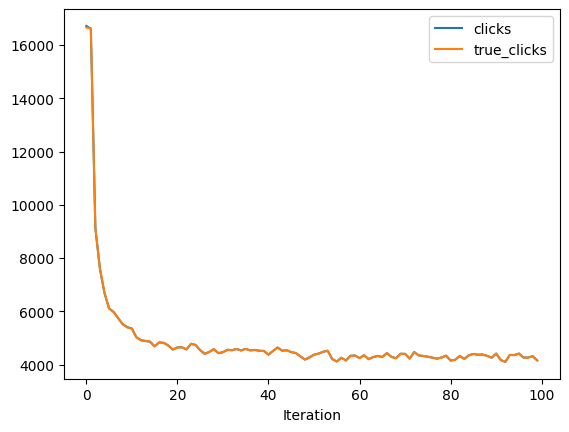

In [23]:
grouped_results_iter.plot(x='Iteration', y=['clicks', 'true_clicks'])

<AxesSubplot:xlabel='Iteration'>

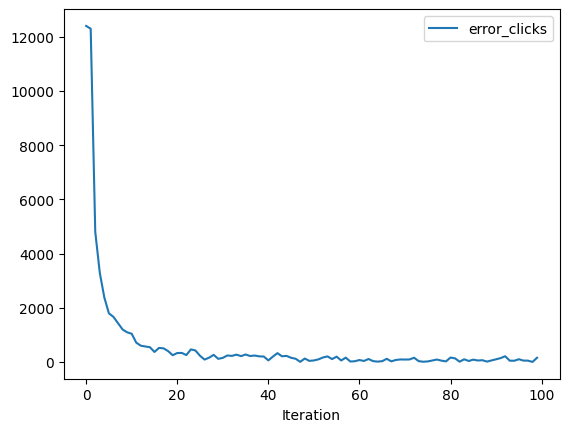

In [25]:
grouped_results_iter.plot(x='Iteration', y=['error_clicks'])

<AxesSubplot:title={'center':'Errore assoluto tra i click ottenuti e i click ottimali'}, xlabel='Iteration'>

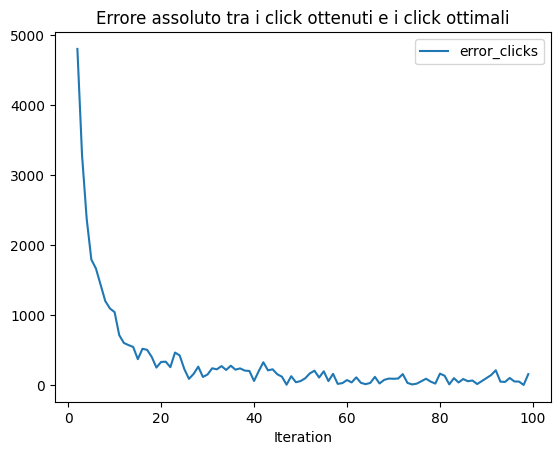

In [28]:
grouped_results_iter[grouped_results_iter['Iteration']>1].plot(x='Iteration', y=['error_clicks'], title='Errore assoluto tra i click ottenuti e i click ottimali')

<AxesSubplot:xlabel='Iteration'>

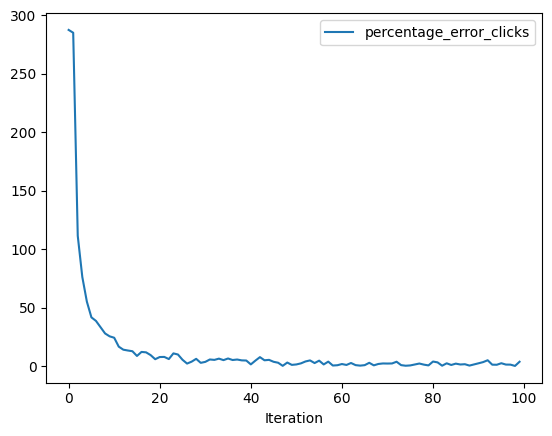

In [26]:
grouped_results_iter.plot(x='Iteration', y=['percentage_error_clicks'])

<AxesSubplot:title={'center':'Errore percentuale tra i click ottenuti e i click ottimali'}, xlabel='Iteration'>

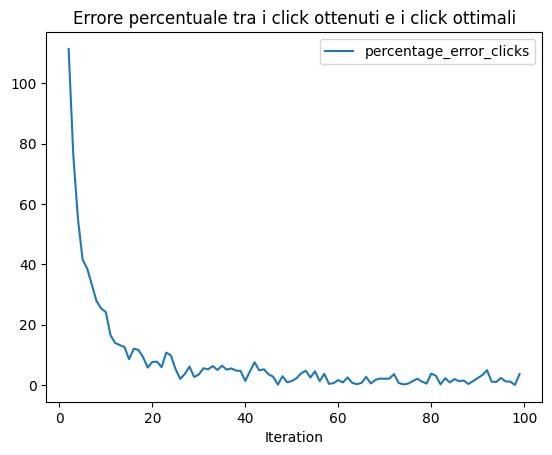

In [29]:
grouped_results_iter[grouped_results_iter['Iteration']>1].plot(x='Iteration', y=['percentage_error_clicks'], title='Errore percentuale tra i click ottenuti e i click ottimali')